
# Electric Network Frequency Analysis
This Notebook is supposed to act as a step-by-step explanation of the
[Electric Network Frequency (ENF) Analysis script](https://github.com/Wuelle/enf_analysis) i made. 
I assume that the reader is familiar with the basic concept of a Fourier Transformation.
If you want to follow along, please run the downloader script and place an arbitrary audio sample in the `data/` directory.<br>
I also want to explicitly thank the students from the University of Wuhan for providing a [Dataset of ENF Recordings](https://github.com/ghuawhu/ENF-WHU-Dataset)

<br>
<em>Supported by National Grid ESO Open Data<em>
<br>

## Table of Contents
* [Introduction](#Introduction)
* [Fourier Transformation](#Fourier-Transformation)
* [Short-time Fourier Transform](#Short-time-Fourier-Transform)
* [Matching the Dataset](#Matching-the-Dataset)



## Introduction
The european powergrid runs on alternating current, with a frequency of, in theory, exactly 50 Hertz. In practice however,
this value fluctuates due to changes in supply and demand. These Fluctuations are usually in the order of < 1Hz and do not affect everyday consumers at all.

Another thing to realize is that alternating current can leave <abbr title="Electric Network Frequency">ENF</abbr>-Artifacts in audio recordings.
The noise is know as the [Mains Hum](https://en.wikipedia.org/wiki/Mains_hum) and in its pure 50 Hz form, it
is too deep to be heard by a human ear. 

Luckily, the british [National Grid ESO](https://data.nationalgrideso.com) provides a 
[free dataset](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) of these frequency variations since January of 2019, which we can use to get the historical data. They record the frequency once per second, which is a lot more than i had initially hoped for.

If however, we extract this background noise and match it with the values from the dataset, we can exactly timestamp the recording.
This process has already been used in court to verify the authenticity of provided audio or to detect evidence of tampering.(because the <abbr title="Electric Network Frequency">ENF</abbr> would suddenly jump around)

Since i only have data from europe, my algorithm is only suitable for audio from europe. It should, however, be possible 
to adapt it to another frequency with only minimal changes. You can find your power grid frequency using the map below.

![Powergrid frequencies across the world](https://upload.wikimedia.org/wikipedia/commons/7/70/World_Map_of_Mains_Voltages_and_Frequencies%2C_Detailed.svg)
*SomnusDe, Public domain, via Wikimedia Commons*

But exactly by how much does the grid frequency fluctuate? According to the [National Grids Mandatory Frequency Response Guide](https://www.nationalgrid.com/sites/default/files/documents/Mandatory%20Frequency%20Response%20Guide%20v1.1.pdf), the grid is considered

|   | unoperational | unstatuory |
| --- | --- | --- |
| below | 49.8Hz | 49.5Hz |
| above | 50.2Hz | 50.5Hz |

We will therefore only perform fourier transformations for the frequencies between 49.5Hz and 50.5Hz. Since the dataset
has a precision up to $\frac{1}{1000}$ of a Hertz, it would be good to match that. We therefore need to perform Fourier transformations for $(50.5 - 49.5) \times 1000 = 1000$ frequencies.
The Nyquist Frequency, which i explain [here](#Nyquist-Frequency), tells us that to analyze frequencies up to 50.5Hz, we will need (at least) a sample rate of 101 samples per second. This is great because .wav files usually sit at around 48000 samples per second. By reducing the number of samples per second, we can greatly reduce the computations required.
If we want precision up to $\frac{1}{100}$ and a maximum of 50.5Hz, we will require $50.5 \times 100 = 5050$ samples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

Matplotlib is building the font cache; this may take a moment.


## Fourier Transformation
The exact Algorithm is beyond the scope of this document, however the Youtube Channel [3b1b](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) provides an [excellent in-depth Explanation](https://www.youtube.com/watch?v=spUNpyF58BY).<br>
TLDR;<br>
A Fourier Transformation is a process by which the underlying frequencies of a noisy signal can be extracted.<br>

### Reading the data
The [data](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) has a resolution of one sample per second. So there is no need to calculate anything more precise than that since we would just be overfitting the data anyway.


In [15]:
from scipy.io import wavfile
from scipy.signal import resample

# change this to 60Hz for US-audio
ENF = 50
# the nth harmonic to analyze
HARMONIC = 1
# bandpass width, in Hz
DELTA = 1
# sample rate (we want 20 data points per cycle)
FS = 20 * ENF
# Nyquist frequency
NYQ = FS // 2


# if you are using your own data, make sure its mono
fs_orig, data_orig = wavfile.read("ENF-WHU-Dataset/ENF-WHU-Dataset/H1/001.wav")
fs_orig_2, control_orig = wavfile.read("ENF-WHU-Dataset/ENF-WHU-Dataset/H0/O01.wav")

data = resample(data_orig, int((data_orig.shape[0] / fs_orig) * FS))
control = resample(data_orig, int((control_orig.shape[0] / fs_orig_2) * FS))

### Applying a Bandpass
Since we are dealing with real-world data, the signal contains **a lot** more frequencies than just the ENF. Since we are not interested in any of them, we can remove them using a bandpass filter that removes all frequencies outside a certain range. Luckily, scipy provides the [signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) filter, which is designed to be as flat as possible within the passband. That way, the frequencies within the band barely get modified.

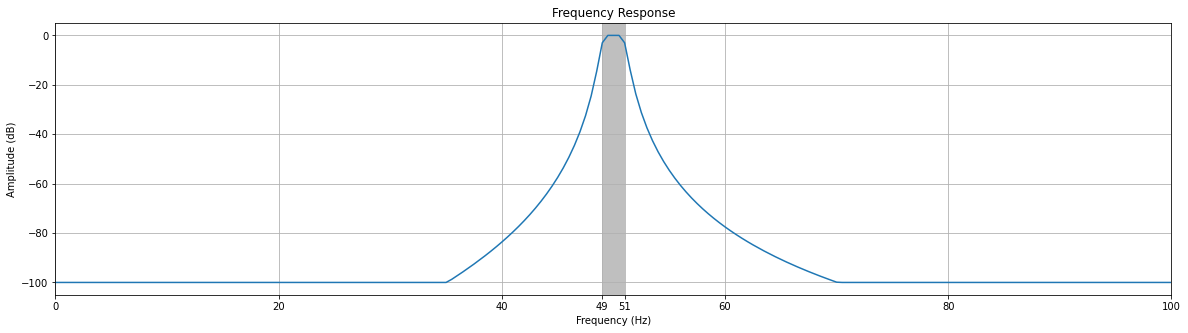

In [17]:
from scipy.signal import butter, freqz, filtfilt

LOWER = (ENF - DELTA) * HARMONIC
UPPER = (ENF + DELTA) * HARMONIC

b, a = butter(4, (LOWER, UPPER), "bandpass", fs=FS)

# test frequency response
freq, h = freqz(b, a, fs=FS, worN=500)

# Convert frequency response to dB (logarithmic scale)
plt.plot(freq, 20*np.log10(np.maximum(abs(h), 1e-5)))
plt.title("Frequency Response")
plt.ylabel("Amplitude (dB)")
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 100])
plt.axvspan(LOWER, UPPER, facecolor="gray", alpha=0.5)
plt.xticks(list(plt.xticks()[0]) + [LOWER, UPPER])
plt.grid()
plt.show()

# Filter the actual data
data = filtfilt(b, a, data)
control = filtfilt(b, a, control)

### Applying a Fourier Transform
Just slicing the wave file to the size of a window is insufficient, since it artificially creates edges at the start and end of the window. To avoid this, we multiply the window by a half cosine function to ensure a smooth transition. (This is called a [Hanning Window](https://numpy.org/doc/stable/reference/generated/numpy.hanning.html))

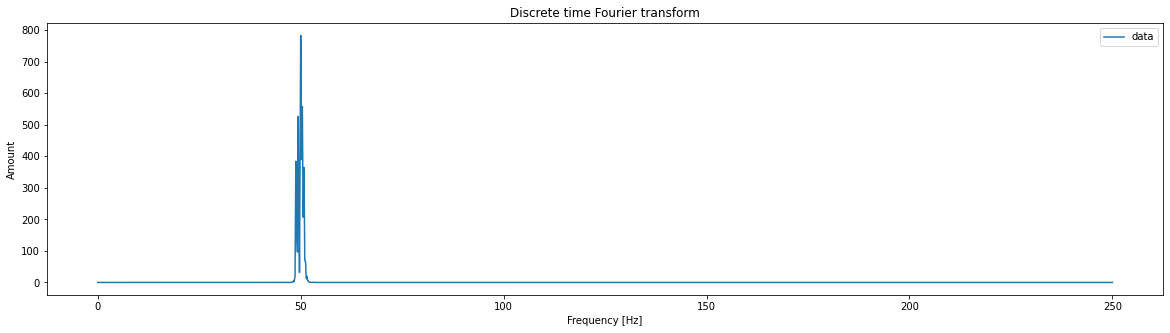

In [19]:
from scipy.fft import next_fast_len, rfft, rfftfreq

window_size = 5000
pad_to = next_fast_len(window_size, real=True)

# FFT for test data
window = data[:window_size] * np.hanning(window_size)
fourier = np.abs(rfft(window, n=pad_to))
frequencies = rfftfreq(window_size, d=1/FS)

# FFT for control data
window = data[:window_size] * np.hanning(window_size)
fourier_control = np.abs(rfft(window, n=pad_to))
frequencies_control = rfftfreq(window_size, d=1/FS)

plt.plot(frequencies, fourier, label = "data")
plt.plot(frequencies_control, fourier_control, label = "control")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amount")
plt.title("Discrete time Fourier transform")
plt.legend()
plt.show()

We can clearly see the spike at approximately 50Hz. This is the noise created by the electric network that we are looking
for. If, at this point, you do not see a spike, the audio does not contain any ENF artifacts and it cannot be timestamped using the
algorithm.

## Cross-correlating with the expected ENF


In [23]:
expected = np.sin(np.linspace(0, data.size * (2 * np.pi / FS), data.size))

## Instantaneous Frequency
There is a huge problem with using Fourier Transforms for analysing frequency variation: it takes a window of audio
and extracts the contained frequencies. But we know that they are not constant. Of course they can approximated to be constant by using a very small window. But since the frequency resolution of the Fourier Transform is given by
$\frac{\mbox{sample frequency}}{\mbox{window size}}$, reducing the window size would also reduce our resolution.

There is a solution for this problem: The [Hilbert Transform](https://en.wikipedia.org/wiki/Hilbert_transform)<br>
There are two different ways to think about frequency:
* Cycles per unit of time
* Angular velocity

Since we already filtered all frequencies that are not close to 50Hz, the Hilbert Transform should only contain 
the ENF Noise we are after.

In [9]:
from scipy.signal import hilbert

analytic_data = hilbert(data)

instantaneous_phase = np.unwrap(np.angle(analytic_data))
instantaneous_frequency = np.diff(instantaneous_phase) / (2 * np.pi) * FS

For fun, lets plot this against the ground truth provided by the students of Wuhan University.

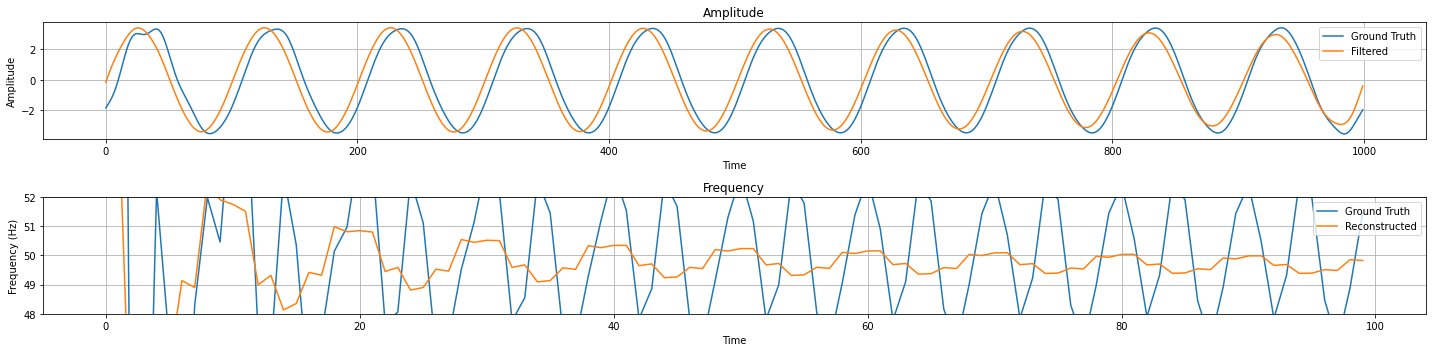

In [10]:
# load the ground truth and apply the Hilbert transform
fs_orig, data_orig = wavfile.read("ENF-WHU-Dataset/ENF-WHU-Dataset/H1_ref/001_ref.wav")
isolated_noise = resample(data_orig, int((data_orig.shape[0] / fs_orig) * FS))

isolated_inst_phase = np.unwrap(np.angle(hilbert(isolated_noise)))
isolated_inst_freq = np.diff(isolated_inst_phase) / (2 * np.pi) * FS

# scale and resample the signal
factor = max(data[:100])/max(isolated_noise[:100])  # ugly hack
y1 = resample(isolated_noise[:100] * factor, 1000)
y2 = resample(data[:100], 1000)


fig, (ax1, ax2) = plt.subplots(2)

# plot amplitude
ax1.plot(y1, label="Ground Truth")
ax1.plot(y2, label="Filtered")
ax1.set_title("Amplitude")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Time")
ax1.grid()
ax1.legend()

# plot frequency
ax2.plot(isolated_inst_freq[:100], label="Ground Truth")
ax2.plot(instantaneous_frequency[:100], label="Reconstructed")
ax2.set_ylim([48, 52])
ax2.set_ylabel("Frequency (Hz)")
ax2.set_xlabel("Time")
ax2.set_title("Frequency")
ax2.grid()
ax2.legend()


plt.tight_layout()
plt.show()

## Matching the Dataset
Thats our ENF-Noise. Now its time to look at the ground truth data (from britain). Since the format from datasets
around the world might differ, you cannot reuse this part with another dataset.

In [ ]:
import pandas as pd

date_parser = lambda date: pd.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
df = pd.read_csv("data/fNew 2020 2.csv", parse_dates=True, date_parser=date_parser)

plt.plot(df.iloc[:, 1].values[:60])
plt.xlabel("Time (s)")
plt.ylabel("ENF (Hz)")
plt.title("Ground Truth")
plt.show()